In [1]:
# Import general libraries
import json
import pandas as pd
import matplotlib.pyplot as plt

# Import local functions
from general_functions import awsOps

In [2]:
# Import data
# Access aws credentials from json file
with open("../aws_credentials.json", 'r') as file:
    aws_creds_json = json.load(file)
# Specify s3 bucket
bucket = "fs-reghub-news-analysis"

# Connect to aws and dowload the files
aws = awsOps(aws_creds_json)
df = aws.get_df(bucket=bucket, file="data_raw_extended.csv")
df_categories = aws.get_df(bucket=bucket, file="rule_labels_v1.csv")

In [3]:
# Add spaces before and after the strings to avoid 
# partially matching wrong words with short keys
df_categories = df_categories.map(lambda x: f' {x} ')

# Clean the df
df.dropna(subset=["news_content"], inplace=True)

# Create a list of the newly created columns for later use
rule_cols = []
# Create rule based category labels
for category in df_categories.columns[1:]:
    # Keep track of which keywords led to categorization
    df_categories[f"{category}_count"] = 0
    # Add columns for rule-based labels
    df[f"rule_labels_{category}"] = "Other"
    rule_cols.append(f"rule_labels_{category}")
    # Match words from the category lists
    for index, row in df.iterrows():
        for word in list(df_categories[category].dropna()):
            if word.lower() in str(row["news_content"]).lower():
                df.at[index, f"rule_labels_{category}"] = category
                df_categories.loc[df_categories[category] == word, f"{category}_count"] += 1

In [4]:
# Compress the four category columns into one
df['rule_labels_comb'] = df[rule_cols].values.tolist()
df['rule_labels_comb'] = df['rule_labels_comb'].apply(lambda lst: [val for val in lst if val != 'Other'])
df.drop(columns=rule_cols, inplace=True)

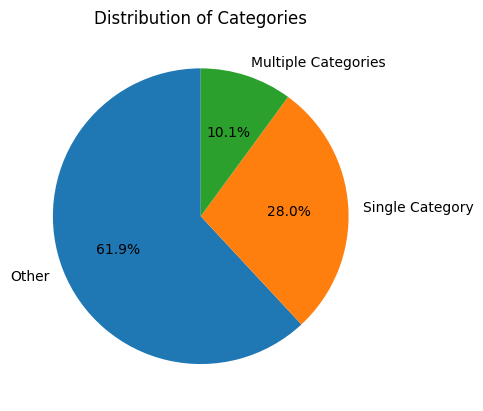

In [5]:
# Visulization 1
count_empty = df['rule_labels_comb'].apply(len).eq(0).sum()
count_single = df['rule_labels_comb'].apply(len).eq(1).sum()
count_multiple = df['rule_labels_comb'].apply(len).gt(1).sum()

# Data for plotting
labels = ['Other', 'Single Category', 'Multiple Categories']
sizes = [count_empty, count_single, count_multiple]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Create a pie chart
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Categories')
plt.show()

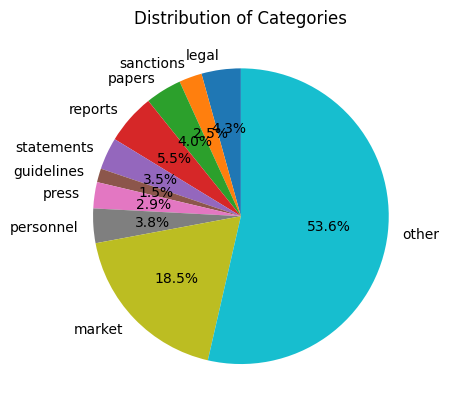

In [6]:
# Visualization 2
vis_cats = []
for category in df_categories.columns[1:10]:
    vis_cats.append(df['rule_labels_comb'].apply(lambda lst: lst.count(category)).sum())
vis_cats.append(df['rule_labels_comb'].apply(len).eq(0).sum())

# Data for plotting
labels = list(df_categories.columns[1:10]) + ["other"]
sizes = vis_cats
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Create a pie chart
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Categories')
plt.show()

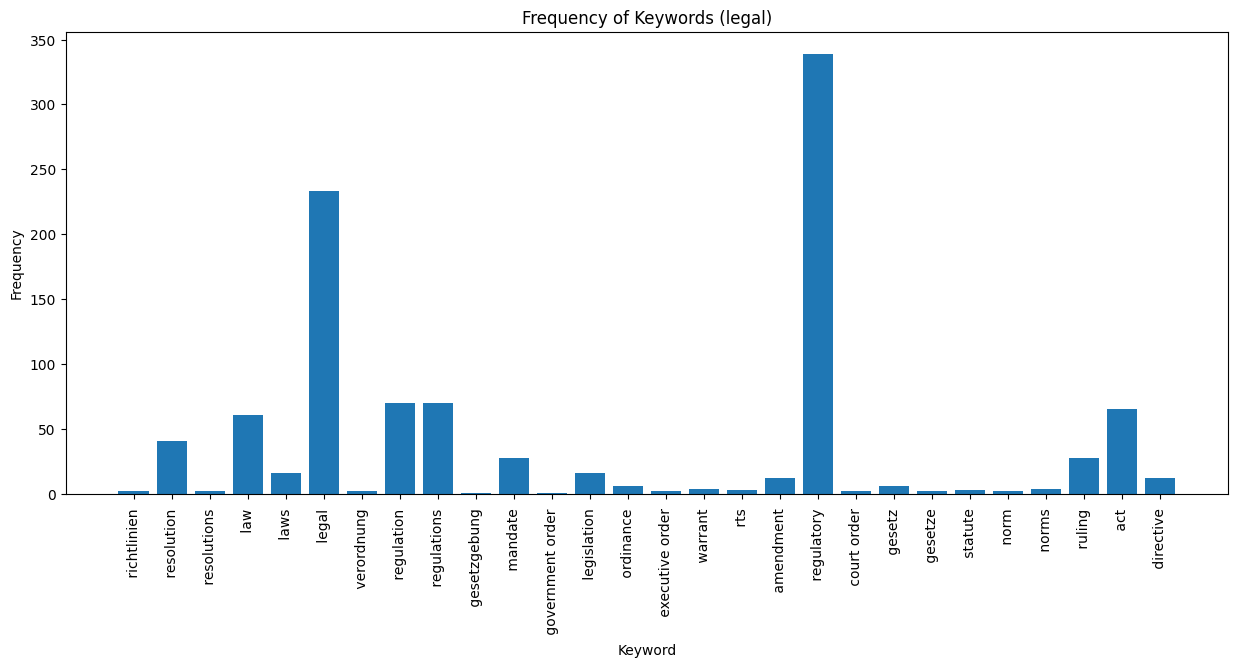

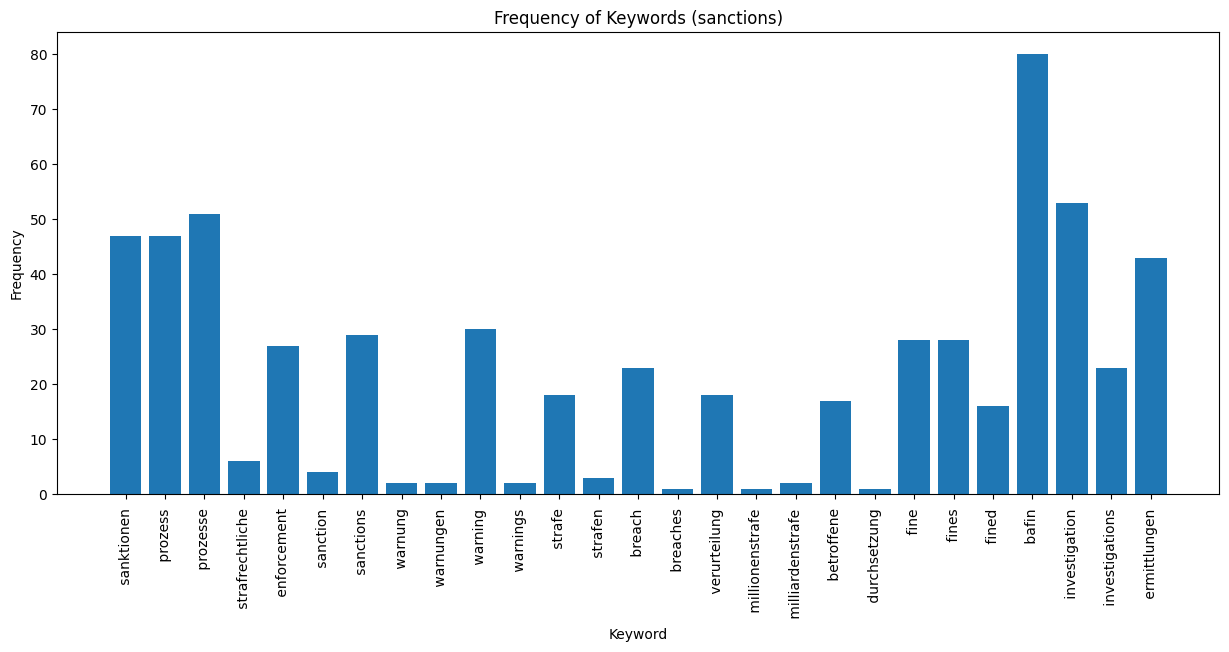

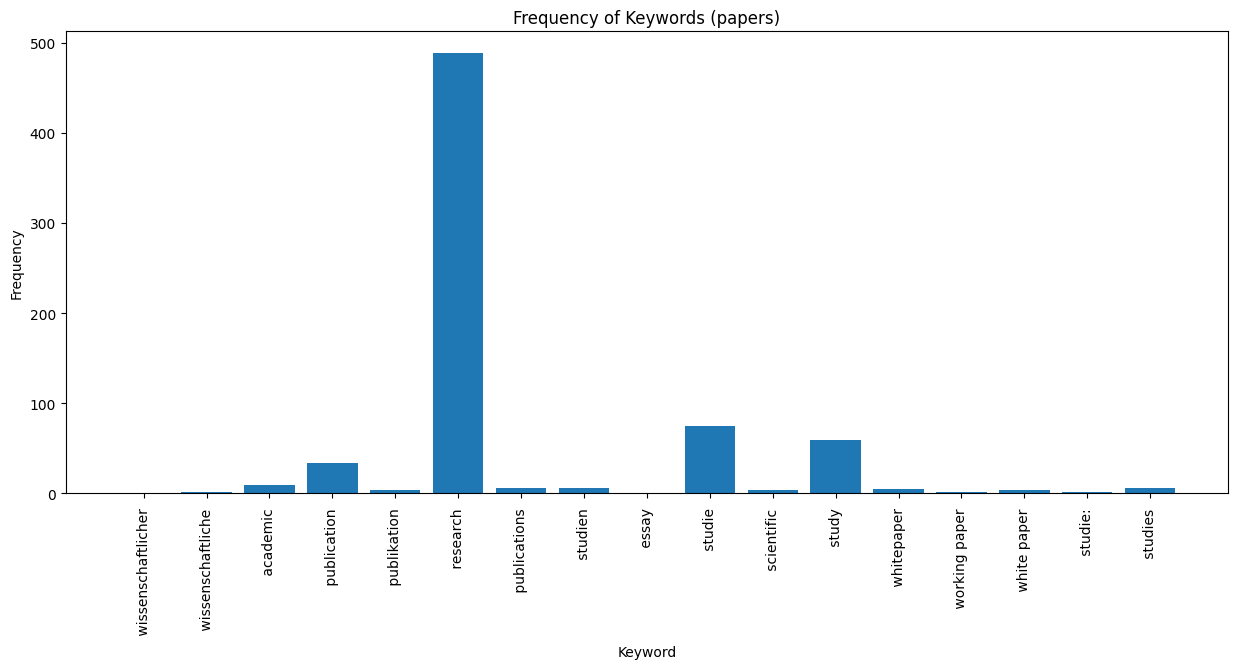

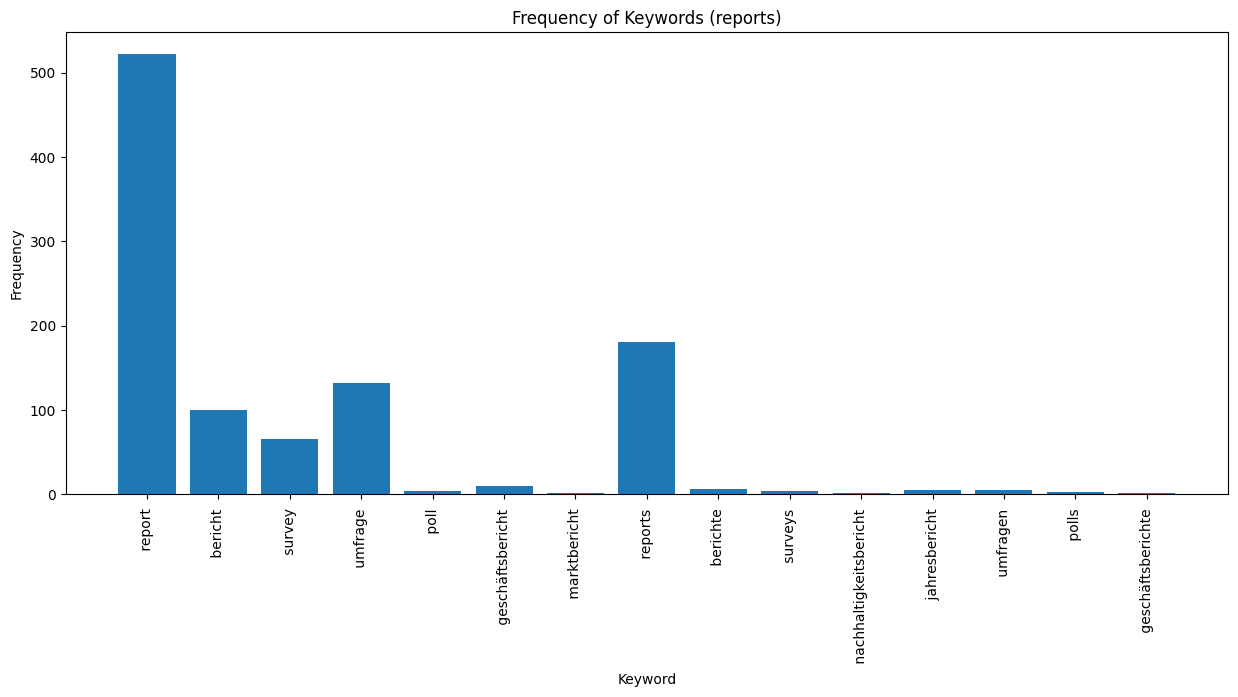

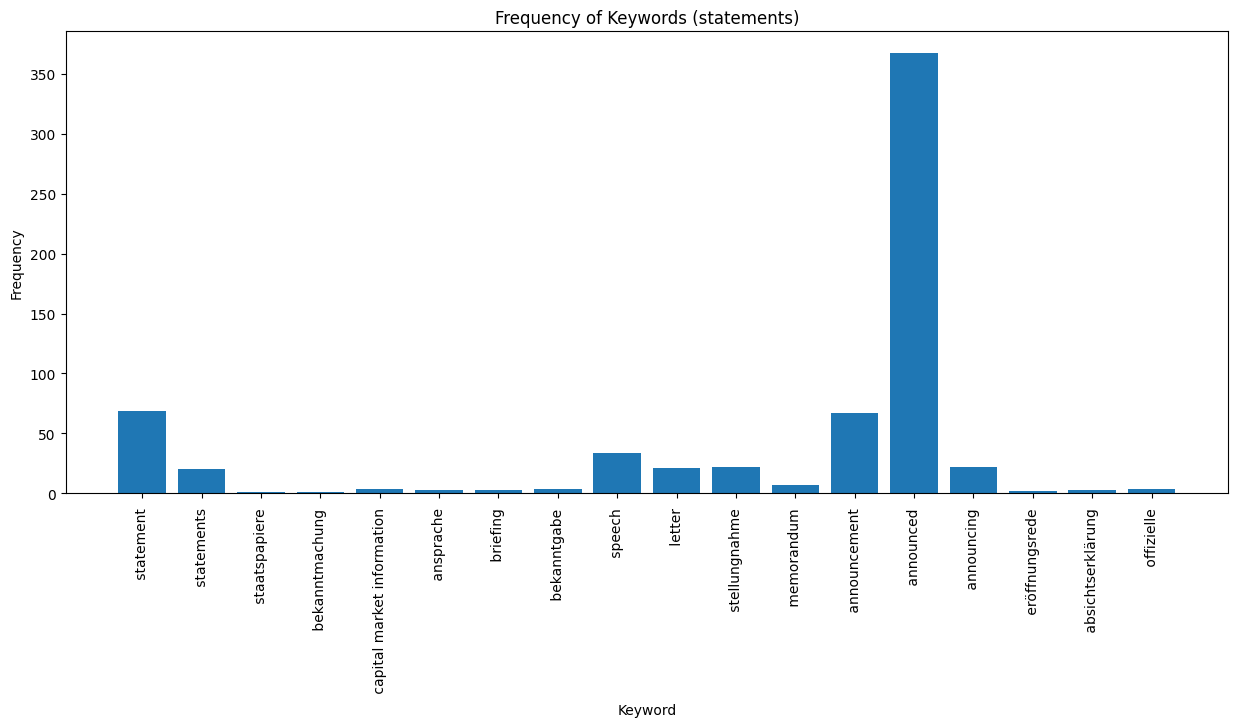

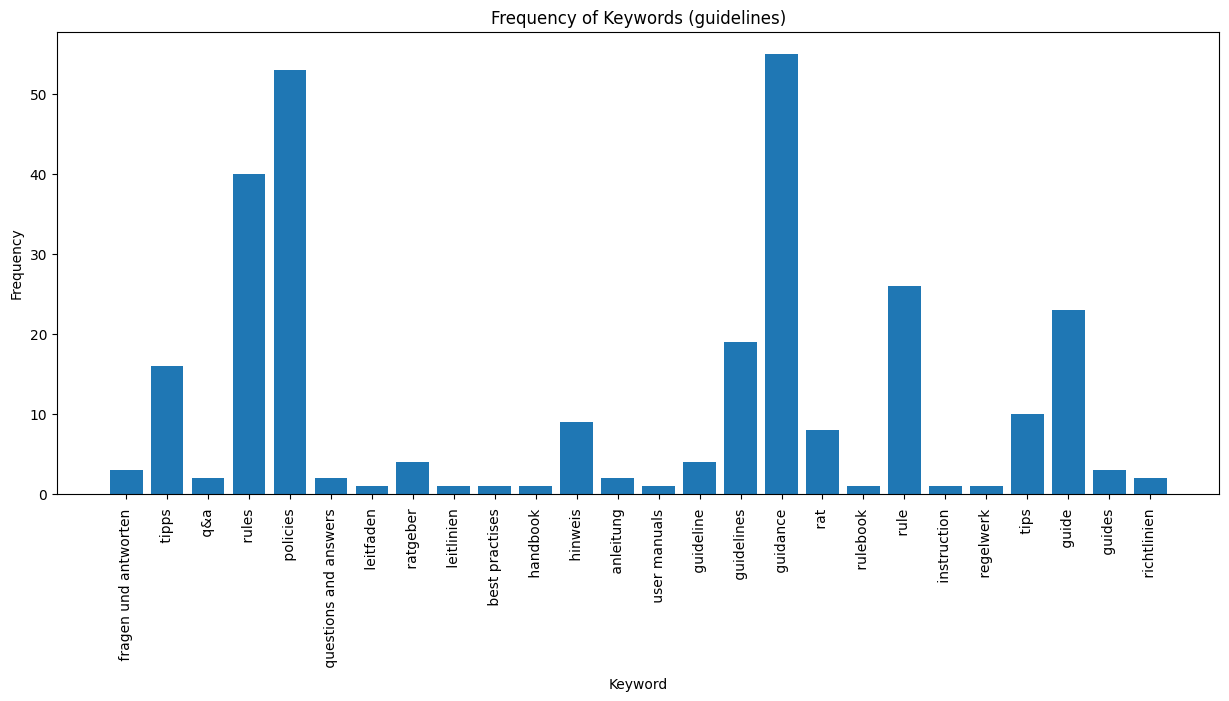

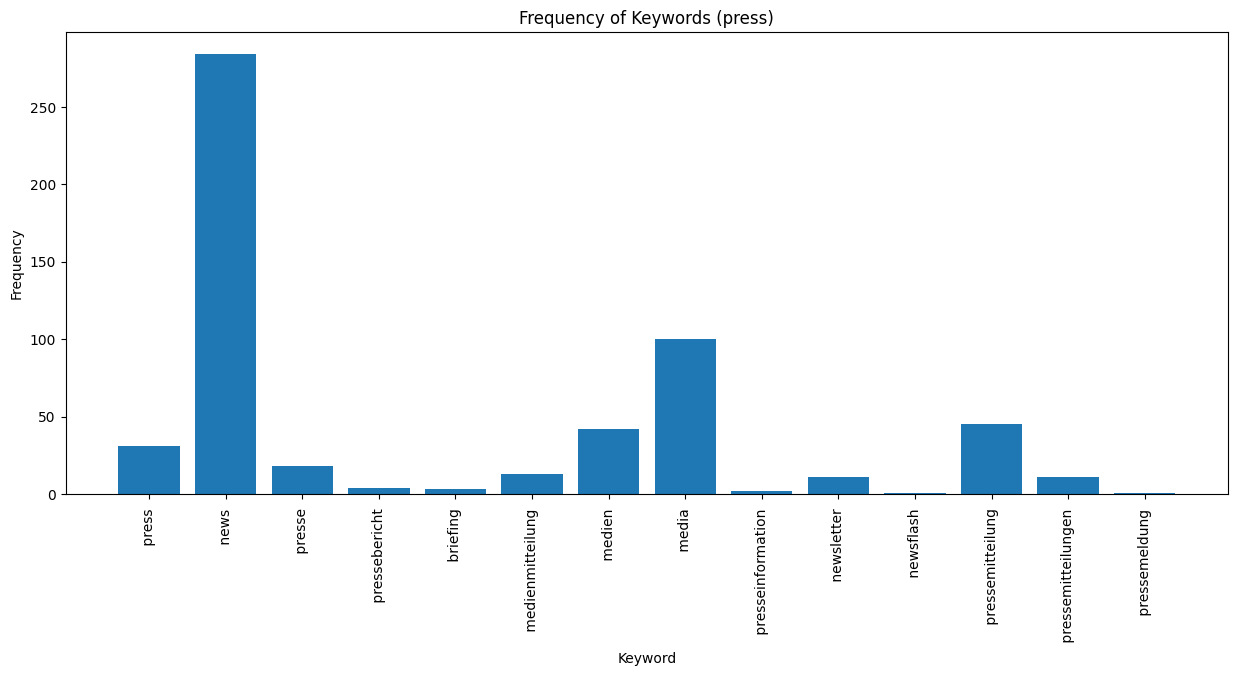

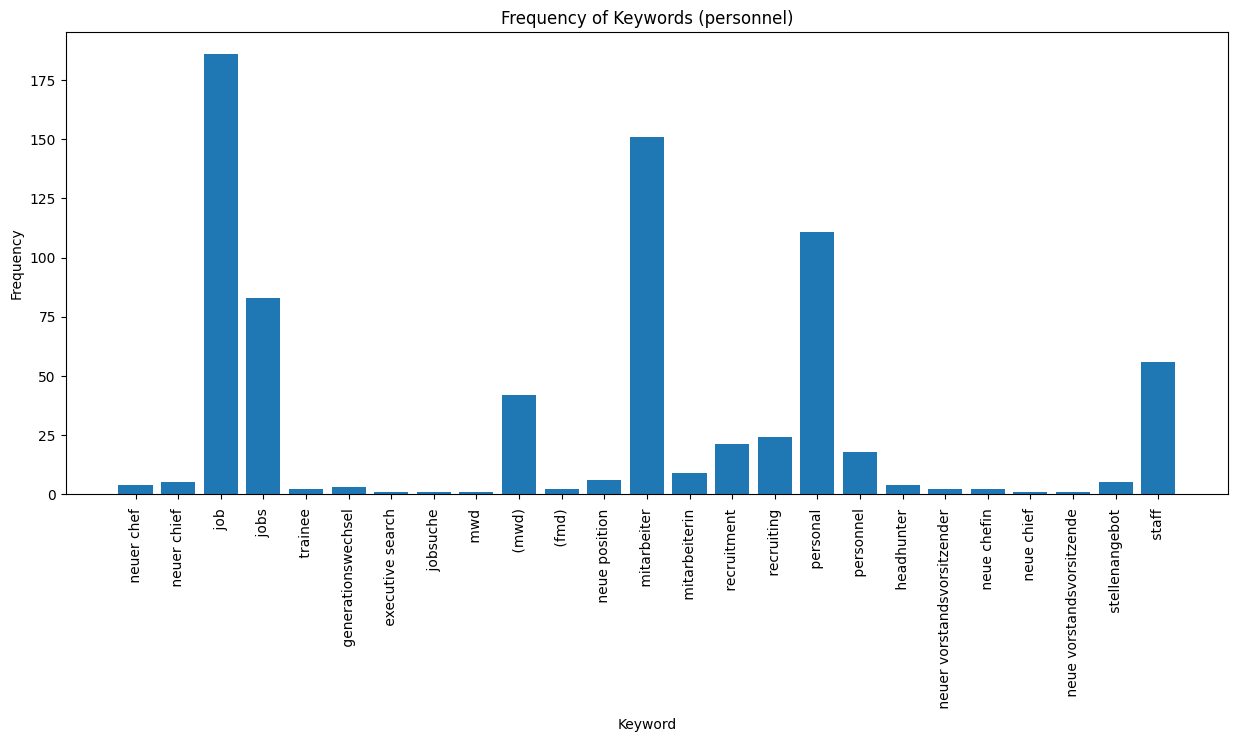

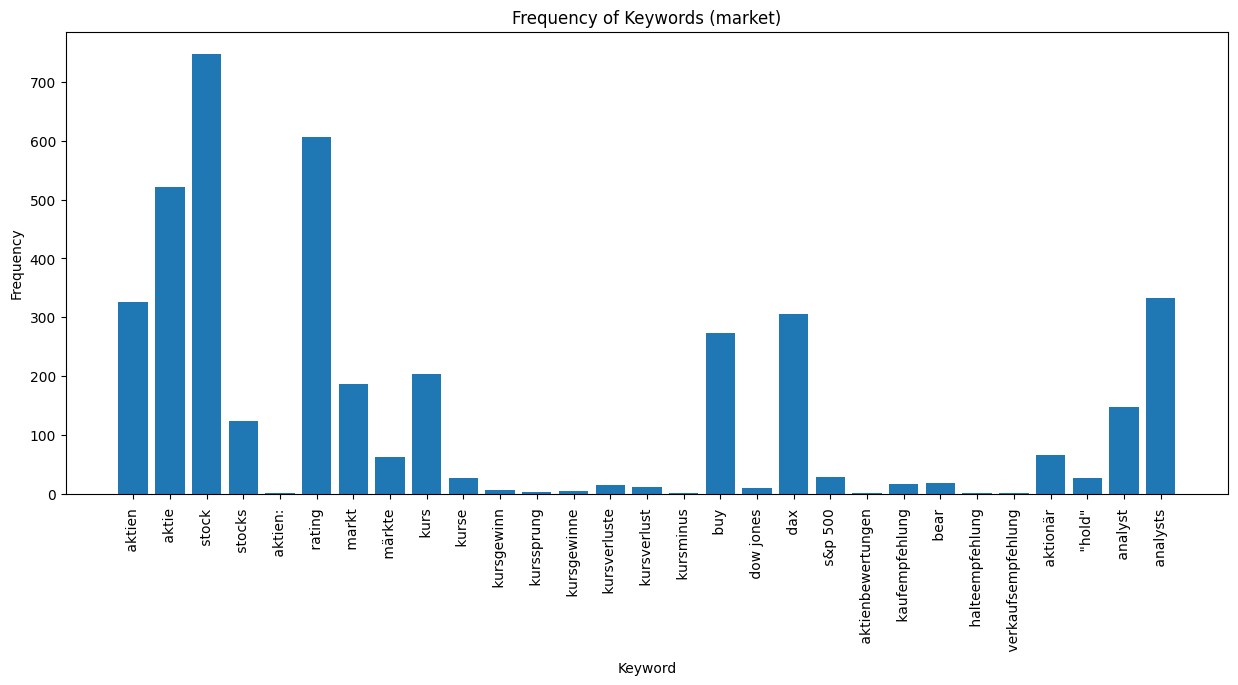

In [7]:
# Visualization 3
for column in df_categories.columns[1:10]:
    # Filter the dataframe for non-zero values in the current column
    df_nonzero = df_categories[df_categories[f"{column}_count"] != 0]

    # Calculate the frequency of each category
    keyword_counts = df_nonzero[f"{column}_count"]
    category_names = df_nonzero[column]

    # Create a bar chart
    plt.figure(figsize=(15, 6))
    plt.bar(category_names, keyword_counts)
    plt.title(f'Frequency of Keywords ({column})')
    plt.xlabel('Keyword')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()

In [8]:
# Save the data as df at desired location
# Local
df.to_csv("../../data_rule_labels_v1.csv")

# AWS
# Access aws credentials from json file
with open("../aws_credentials.json", 'r') as file:
    aws_creds_json = json.load(file)
# Specify s3 bucket
bucket = "fs-reghub-news-analysis"

# Connect to aws and upload the file
aws = awsOps(aws_creds_json)
aws.upload_file(bucket=bucket, path="../../data_rule_labels_v1.csv", name="data_rule_labels_v1.csv")

'File uploaded'